In [297]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [298]:
with open('models/gb_home.pkl', 'rb') as f:
    home_md = pickle.load(f)

with open('models/gb_away.pkl', 'rb') as f:
    away_md = pickle.load(f)

In [262]:
model_home = load_model('./models/model_home_nn.h5')

model_away = load_model('./models/model_away_nn.h5')

In [299]:
teams_data = pd.read_csv("datasets/created/new_model.csv")


In [300]:
teams_data['home_team'].value_counts()

home_team
Mexico           151
United States    138
Argentina        124
Brazil           114
Colombia         103
Peru             101
Chile             97
Venezuela         94
Ecuador           90
Uruguay           83
Bolivia           79
Paraguay          75
Costa Rica        67
Panama            58
Jamaica           49
Canada            29
Name: count, dtype: int64

In [301]:
def find_team_features(home, away):
    home_infos = teams_data[(teams_data.home_team == home) | (teams_data.away_team == home)].tail(1)
    if home_infos.home_team.values[0] == home:
        home_away_goal_suf_mean = home_infos["away_goal_suf_mean"].values[0]
        home_away_goals_mean = home_infos["away_goals_mean"].values[0]
        home_home_goals_mean = home_infos["home_goals_mean"].values[0]
        home_home_goal_suf_mean = home_infos["home_goals_suf_mean"].values[0]
        home_rank = home_infos["rank_home"].values[0]
    else:
        home_away_goal_suf_mean = home_infos["home_goals_suf_mean"].values[0]
        home_away_goals_mean = home_infos["home_goals_mean"].values[0]
        home_home_goals_mean = home_infos["away_goals_mean"].values[0]
        home_home_goal_suf_mean = home_infos["away_goals_suf_mean"].values[0]
        home_rank = home_infos["rank_away"].values[0]
        
    
    away_infos = teams_data[(teams_data.home_team == away) | (teams_data.away_team == away)].tail(1)
    if away_infos.home_team.values[0] == away:
        away_away_goals_mean = away_infos["away_goals_mean"].values[0]
        away_away_goals_suf_mean = away_infos["away_goals_suf_mean"].values[0]
        away_home_goals_suf_mean = away_infos["home_goals_suf_mean"].values[0]
        away_home_goals_mean = away_infos["home_goals_mean"].values[0]
        away_rank = away_infos["rank_home"].values[0]
    else:
        away_away_goals_mean = away_infos["home_goals_mean"].values[0]
        away_away_goals_suf_mean = away_infos["home_goals_suf_mean"].values[0]
        away_home_goals_suf_mean = away_infos["away_goals_suf_mean"].values[0]
        away_home_goals_mean = away_infos["away_goals_mean"].values[0]
        away_rank = away_infos["rank_away"].values[0]

    #print(home_rank, away_rank)
    rank_dif = home_rank - away_rank
    ht_features = [
        home_away_goal_suf_mean*rank_dif,
        home_away_goals_mean*rank_dif,
        home_home_goals_mean*rank_dif,
        home_home_goal_suf_mean*rank_dif
    ]
    
    at_features = [
        away_away_goals_mean*rank_dif,
        away_away_goals_suf_mean*rank_dif,
        away_home_goals_suf_mean*rank_dif,
        away_home_goals_mean*rank_dif
    ]
    return ht_features, at_features

In [302]:
with open('models/scaler_away.pkl', 'rb') as f:
    scaler_away = pickle.load(f)

In [303]:
argentina, canada = find_team_features("Uruguay", "Argentina")

In [304]:
xg_argentina = home_md.predict([argentina])
xg_canada = away_md.predict([canada])


In [280]:
argentina_array = np.array([argentina])
argentina_array_scaled = scaler_away.transform(argentina_array)

xg_argentina = model_home.predict(argentina_array_scaled)

/home/yoni/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


In [281]:
canada_array = np.array([canada])
canada_array_scaled = scaler_away.transform(canada_array)
xg_canada = model_away.predict(canada_array_scaled)


/home/yoni/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


In [320]:
from scipy.stats import poisson
poisson_probs_argentina = poisson.pmf(np.arange(0, 5), xg_argentina)
poisson_probs_canada = poisson.pmf(np.arange(0, 5), xg_canada)

#poisson_probs_argentina = poisson_probs_argentina.flatten()
#poisson_probs_canada = poisson_probs_canada.flatten()

print(poisson_probs_argentina)

[0.26847415 0.35304368 0.23212633 0.10174876 0.03344992]


In [321]:
print(poisson_probs_canada)

[0.02874093 0.10201401 0.18104595 0.21420349 0.19007523]


In [322]:
def plot_poisson(x, poisson_probs, team):
    plt.figure(figsize=(10, 6))
    plt.bar(x, poisson_probs, alpha=0.6, color='blue')
    plt.plot(x, poisson_probs, 'bo', ms=8)
    plt.title(f'Poisson Distribution - {team}')
    plt.xlabel('Number of Events')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

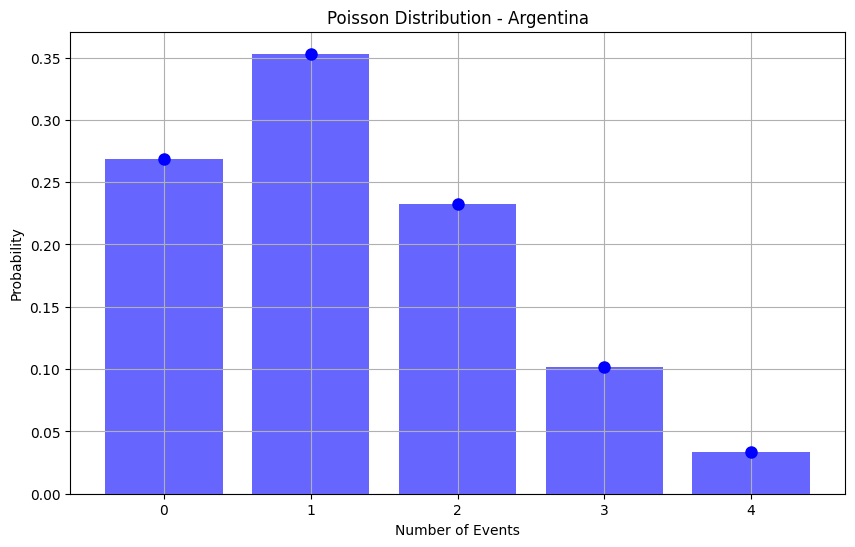

In [324]:
plot_poisson(np.arange(0,5), poisson_probs_argentina, "Argentina")


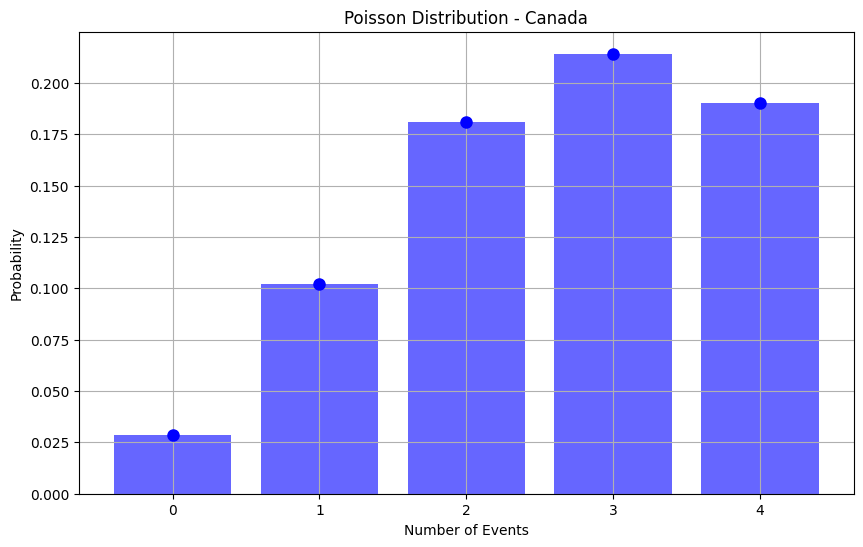

In [325]:
plot_poisson(np.arange(0,5), poisson_probs_canada, "Canada")


In [326]:
res_track = np.zeros((10,10))

for i in range(len(poisson_probs_argentina)):
    for j in range(len(poisson_probs_canada)):
        res_prob = poisson_probs_argentina[i]*poisson_probs_canada[j]
        res_track[j][i] = res_prob

In [327]:
poisson_probs_argentina


array([0.26847415, 0.35304368, 0.23212633, 0.10174876, 0.03344992])

In [328]:
poisson_probs_canada


array([0.02874093, 0.10201401, 0.18104595, 0.21420349, 0.19007523])

In [329]:
res_df = pd.DataFrame(res_track)


In [330]:
res_df.columns = ["Uruguay " + str(a) for a in res_df.columns] 
res_df.index = ["Argentina " + str(a) for a in res_df.index] 

In [331]:
def style_specific_cells(x):
    color = ''
    
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if i == j:
                color = 'background-color: yellow'
            elif j > i:
                color = 'background-color: lightgreen'
            else:
                color = 'background-color: lightcoral'
            df_styled.iloc[i, j] = color
    return df_styled

In [332]:
res_df.style.format("{:.2%}").apply(style_specific_cells, axis=None)


,Uruguay 0,Uruguay 1,Uruguay 2,Uruguay 3,Uruguay 4,Uruguay 5,Uruguay 6,Uruguay 7,Uruguay 8,Uruguay 9
Argentina 0,0.77%,1.01%,0.67%,0.29%,0.10%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 1,2.74%,3.60%,2.37%,1.04%,0.34%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 2,4.86%,6.39%,4.20%,1.84%,0.61%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 3,5.75%,7.56%,4.97%,2.18%,0.72%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 4,5.10%,6.71%,4.41%,1.93%,0.64%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 5,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 6,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 7,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 8,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Argentina 9,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [333]:
def find_probs(poisson_home, poisson_away):
    home_probs = []
    away_probs = []
    
    draw_probs = []
    
    for i in range(len(poisson_home)):
        for j in range(len(poisson_away)):
            res_prob = poisson_home[i]*poisson_away[j]
            
            if i == j:
                draw_probs.append(res_prob)
            elif i > j:
                home_probs.append(res_prob)
            elif j > i:
                away_probs.append(res_prob)
            #res_track[j][i] = res_prob
    
    
    return sum(home_probs), sum(draw_probs), sum(away_probs), poisson_home.tolist().index(max(poisson_home.tolist())), poisson_away.tolist().index(max(poisson_away.tolist()))

In [334]:
gw, draw, sw, g1, g2 = find_probs(poisson_probs_argentina, poisson_probs_canada)


In [335]:
print(f"Argentina Wins: {gw:.2%}")
print(f"Draw: {draw:.2%}")
print(f"Canada Wins: {sw:.2%}")
print(f"most prob result {g1} - {g2}")

Argentina Wins: 8.98%
Draw: 11.39%
Canada Wins: 50.44%
most prob result 1 - 3


# Complete Simulation

In [502]:
matches = pd.read_csv("./datasets/created/copa_america_countries_results.csv")

In [470]:
matches.home_team.unique()

array(['United States', 'Argentina', 'Mexico', 'Peru', 'Brazil',
       'Costa Rica', 'Paraguay', 'Venezuela', 'Colombia', 'Uruguay',
       'Bolivia', 'Ecuador', 'Chile', 'Jamaica', 'Canada', 'Panama'],
      dtype=object)

In [471]:
matches

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
0,2019-01-27,United States,Panama,3,0,Friendly,Glendale,United States,False,Home
1,2019-02-02,United States,Costa Rica,2,0,Friendly,San Jose,United States,False,Home
2,2019-03-21,United States,Ecuador,1,0,Friendly,Orlando,United States,False,Home
3,2019-03-22,Argentina,Venezuela,1,3,Friendly,Madrid,Spain,True,Away
4,2019-03-22,Mexico,Chile,3,1,Friendly,San Diego,United States,True,Home
...,...,...,...,...,...,...,...,...,...,...
321,2024-06-11,Chile,Paraguay,3,0,Friendly,Santiago,Chile,False,Home
322,2024-06-12,Ecuador,Bolivia,3,1,Friendly,Chester,United States,True,Home
323,2024-06-12,United States,Brazil,1,1,Friendly,Orlando,United States,False,Draw
324,2024-06-15,Colombia,Bolivia,3,0,Friendly,Denver,United States,True,Home


In [140]:
group_dict_manopla = {'A': {'Argentina': [0, 0, 0], 'Peru': [0, 0, 0], 'Chile': [0, 0, 0], 'Canada': [0, 0, 0]},
    'B': {'Mexico': [0, 0, 0], 'Ecuador': [0, 0, 0],'Venezuela': [0, 0, 0],'Jamaica': [0, 0, 0]},
    'C': {'United States': [0, 0, 0],'Uruguay': [0, 0, 0],'Panama': [0, 0, 0],'Bolivia': [0, 0, 0]},
    'D': {'Brazil': [0, 0, 0],'Colombia': [0, 0, 0],'Paraguay': [0, 0, 0],'Costa Rica': [0, 0, 0]}}

group_dict_manopla

{'A': {'Argentina': [0, 0, 0],
  'Peru': [0, 0, 0],
  'Chile': [0, 0, 0],
  'Canada': [0, 0, 0]},
 'B': {'Mexico': [0, 0, 0],
  'Ecuador': [0, 0, 0],
  'Venezuela': [0, 0, 0],
  'Jamaica': [0, 0, 0]},
 'C': {'United States': [0, 0, 0],
  'Uruguay': [0, 0, 0],
  'Panama': [0, 0, 0],
  'Bolivia': [0, 0, 0]},
 'D': {'Brazil': [0, 0, 0],
  'Colombia': [0, 0, 0],
  'Paraguay': [0, 0, 0],
  'Costa Rica': [0, 0, 0]}}

In [141]:
#get the group A of the dictionary
group_dict_manopla['A']


{'Argentina': [0, 0, 0],
 'Peru': [0, 0, 0],
 'Chile': [0, 0, 0],
 'Canada': [0, 0, 0]}

In [142]:
from itertools import combinations

all_combinations = []

for group, teams in group_dict_manopla.items():
    # Obtener todas las combinaciones de a dos equipos del grupo actual
    group_combinations = list(combinations(teams.keys(), 2))
    all_combinations.extend(group_combinations)

# Imprimir todas las combinaciones obtenidas
print("Todas las combinaciones de equipos:")
for comb in all_combinations:
    print(comb)

Todas las combinaciones de equipos:
('Argentina', 'Peru')
('Argentina', 'Chile')
('Argentina', 'Canada')
('Peru', 'Chile')
('Peru', 'Canada')
('Chile', 'Canada')
('Mexico', 'Ecuador')
('Mexico', 'Venezuela')
('Mexico', 'Jamaica')
('Ecuador', 'Venezuela')
('Ecuador', 'Jamaica')
('Venezuela', 'Jamaica')
('United States', 'Uruguay')
('United States', 'Panama')
('United States', 'Bolivia')
('Uruguay', 'Panama')
('Uruguay', 'Bolivia')
('Panama', 'Bolivia')
('Brazil', 'Colombia')
('Brazil', 'Paraguay')
('Brazil', 'Costa Rica')
('Colombia', 'Paraguay')
('Colombia', 'Costa Rica')
('Paraguay', 'Costa Rica')


In [143]:
for match in all_combinations:
    home_team = match[0]
    away_team = match[1]
    print(home_team)


    home_features, away_features = find_team_features(home_team, away_team)
    xg_home = home_md.predict([home_features])[0]
    xg_away = away_md.predict([away_features])[0]

    print(f"xg_home: {xg_home:.2f}")
    print(f"xg_away: {xg_away:.2f}")

    poisson_probs_home = poisson.pmf(np.arange(0, 10), xg_home)
    poisson_probs_away = poisson.pmf(np.arange(0, 10), xg_away)

    gw, draw, sw, g1, g2 = find_probs(poisson_probs_home, poisson_probs_away)

    print(f"{home_team} vs {away_team}")
    print(f"{home_team} Wins: {gw:.2%}")
    print(f"Draw: {draw:.2%}")
    print(f"{away_team} Wins: {sw:.2%}")
    print(f"most prob result {g1} - {g2}")




    #print the feature
    

Argentina
xg_home: 1.50
xg_away: 0.70
Argentina vs Peru
Argentina Wins: 56.62%
Draw: 26.13%
Peru Wins: 17.25%
most prob result 1 - 0
Argentina
xg_home: 1.82
xg_away: 0.32
Argentina vs Chile
Argentina Wins: 74.36%
Draw: 19.75%
Chile Wins: 5.89%
most prob result 1 - 0
Argentina
xg_home: 1.78
xg_away: 0.42
Argentina vs Canada
Argentina Wins: 70.89%
Draw: 21.08%
Canada Wins: 8.02%
most prob result 1 - 0
Peru
xg_home: 1.48
xg_away: 1.08
Peru vs Chile
Peru Wins: 46.32%
Draw: 26.02%
Chile Wins: 27.67%
most prob result 1 - 1
Peru
xg_home: 1.38
xg_away: 0.77
Peru vs Canada
Peru Wins: 51.42%
Draw: 27.69%
Canada Wins: 20.89%
most prob result 1 - 0
Chile
xg_home: 2.19
xg_away: 0.83
Chile vs Canada
Chile Wins: 68.26%
Draw: 18.76%
Canada Wins: 12.97%
most prob result 2 - 0
Mexico
xg_home: 1.47
xg_away: 0.77
Mexico vs Ecuador
Mexico Wins: 53.73%
Draw: 26.55%
Ecuador Wins: 19.72%
most prob result 1 - 0
Mexico
xg_home: 1.68
xg_away: 0.71
Mexico vs Venezuela
Mexico Wins: 60.64%
Draw: 23.79%
Venezuela Wi

In [350]:
#for each possible match in the all_combinations list we will predict the result
for match in all_combinations:
    home_team = match[0]
    away_team = match[1]
    
    home_team_goals = 0
    away_team_goals = 0
    
    # Get the features for the home and away team
    home_features, away_features = find_team_features(home_team, away_team)
    
    # Predict the expected goals for the home and away team
    xg_home = home_md.predict([home_features])[0]
    xg_away = away_md.predict([away_features])[0]
    
    # Get the poisson distribution for the home and away team
    poisson_probs_home = poisson.pmf(np.arange(0, 10), xg_home)
    poisson_probs_away = poisson.pmf(np.arange(0, 10), xg_away)
    
    # Get the probabilities for the home team win, draw and away team win
    gw, draw, sw, g1, g2 = find_probs(poisson_probs_home, poisson_probs_away)
    
    # Update the dictionary with the results of the match
    group_dict_manopla[matches[matches['home_team'] == home_team].group.values[0]][home_team][0] += gw
    group_dict_manopla[matches[matches['home_team'] == home_team].group.values[0]][home_team][1] += draw
    group_dict_manopla[matches[matches['home_team'] == home_team].group.values[0]][home_team][2] += sw
    
    group_dict_manopla[matches[matches['away_team'] == away_team].group.values[0]][away_team][0] += sw
    group_dict_manopla[matches[matches['away_team'] == away_team].group.values[0]][away_team][1] += draw
    group_dict_manopla[matches[matches['away_team'] == away_team].group.values[0]][away_team][2] += gw
    
    print(f"{home_team} vs {away_team}")
    print(f"Argentina Wins: {gw:.2%}")
    print(f"Draw: {draw:.2%}")
    print(f"Uruguay Wins: {sw:.2%}")
    print(f"most prob result {g1} - {g2}")
    print("\n")

group_dict_manopla


AttributeError: 'DataFrame' object has no attribute 'group'